In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

import PIL
from matplotlib import pyplot as plt

# Downloading and preprocessing MNIST ds

In [64]:

# Преобразования для нормализации изображений
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))]) 

# Загрузка обучающего и тестового наборов данных MNIST
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

Тут возник вопрос, как праильно вычислять mean и std:
По всему data set'у или в каждом изображении/батче отдельно?

значения 0.5 и 0.5 были взяты из интернета, когда я гуглил про то, как скачать mnist

In [65]:
print('Train data set size:', len(train_dataset),'\n', 'Test data set size:', len(test_dataset))


Train data set size: 60000 
 Test data set size: 10000


## Making a Dataloader 

In [66]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## Transfer to CUDA if it is available 

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Current device for running and trainning:', device)

Current device for running and trainning: cuda


Я юы хотел перенести dataset или dataloader сразу все данные, но попытки были безуспешны.

Как можно перенести данные на cuda до начала цикла обучения ?

там не так много данных и я могу себе позволить перенести весь датасет на видеокарту 

я не знаю как inplace изменить dataset или dataloader что бы применить one hot и labels. Придется каждый раз считать это в цикле обучения(

# Model creating and training

In [68]:
print(train_dataset[0][0].shape)

torch.Size([1, 28, 28])


входное изображение 28х28

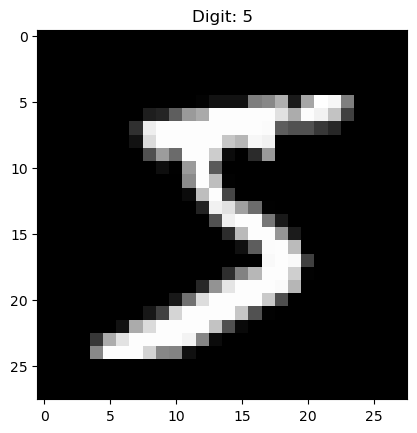

In [69]:
test_img, label = train_dataset[0]
test_img = test_img.squeeze()  # Убираем размерность канала, если она равна 1

# Вывод изображения с помощью Matplotlib
plt.imshow(test_img, cmap='gray')
plt.title(f"Digit: {label}")
plt.show()

обучающая функция

вынес ее отдельно тк она общая для каждой модели

In [133]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total_size = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)
            
            total_size += labels.shape[0]
            correct += int((predicted == labels).sum())
    #print("Accuracy:", correct / total_size)
    #print('True predicted', correct, '/', total_size)
        return correct, total_size

In [134]:
import datetime
num_classes = 10 # from 0 to 9

#labels = torch.empty(batch_size, num_classes, )
#labels = labels.to(device)

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader: 
            imgs = imgs.to(device)
            labels = labels.to(device)
            labels = torch.eye(num_classes).to(device)[labels]#.to(device)
            
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), epoch,
                loss_train / len(train_loader)))
            correct, total_size = evaluate_model(model, test_loader)
            print("\tAccuracy:", correct / total_size)
            #print('True predicted', correct, '/', total_size)

            

## Ordinary model
попробуем без Dropout, Batchnorm и Skipconnection

этот кусок кода я скопировал из книжки и немного дополнил - one hot encoding для lable

In [135]:
conv1_out_ch = 16
conv2_out_ch = 8
kernel_size = 3

ordinary_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(8 * 7 * 7, 32),
            nn.ReLU(),
            nn.Linear(32, 10))

ordinary_model.to(device)

learning_rate = 1e-2

optimizer = optim.SGD(ordinary_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, ordinary_model, loss_fn, train_loader)

2023-08-25 17:34:25 Epoch 1, Training loss 1.089393458513817
	Accuracy: 0.897
2023-08-25 17:36:13 Epoch 10, Training loss 0.06659484190542672
	Accuracy: 0.9826
2023-08-25 17:38:18 Epoch 20, Training loss 0.040947373791623595
	Accuracy: 0.9857
2023-08-25 17:40:18 Epoch 30, Training loss 0.03044464245001956
	Accuracy: 0.9882
2023-08-25 17:42:18 Epoch 40, Training loss 0.02358030447807001
	Accuracy: 0.9885
2023-08-25 17:44:21 Epoch 50, Training loss 0.01897390819630518
	Accuracy: 0.9894
2023-08-25 17:46:21 Epoch 60, Training loss 0.015030871789318449
	Accuracy: 0.9892
2023-08-25 17:48:21 Epoch 70, Training loss 0.012116988112872677
	Accuracy: 0.9888
2023-08-25 17:50:24 Epoch 80, Training loss 0.009551386542041846
	Accuracy: 0.9883
2023-08-25 17:52:23 Epoch 90, Training loss 0.007643287306517621
	Accuracy: 0.9888
2023-08-25 17:54:24 Epoch 100, Training loss 0.005937199195808007
	Accuracy: 0.9889


In [123]:
evaluate_model(ordinary_model, test_loader)

Accuracy: 0.9861
True predicted 9861 / 10000


Даже обычная сверточная модел без Dropout, Batchnorm и Skipconnection справилась на этом датасете неплохо(хотя и датасет простой)

1st Test:  
Точность: 98.74%  
Праильно: 9874 / 10_000  

2nd Test:  
Точность: 98.61%  
Праильно: 9861 / 10_000  
из-за своего косяка мне пришлось дважды обучить модель, поэтому тут два теста

3rd Test:
Точность: 98.89%  
Праильно: 9898 / 10_000  
лучший результат достигается в самом конце

Тут возникает вопрос, стоит ли улучшать модель, тк улучшения могут быть и не особо заметны, но почему бы и нет 

## Ordinary model + Tanh
Хочу протестировать с другой функцией активации 

Заменим все ReLU на Tanh

In [136]:
conv1_out_ch = 16
conv2_out_ch = 8
kernel_size = 3

model_tanh = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(8 * 7 * 7, 32),
            nn.Tanh(),
            nn.Linear(32, 10))

model_tanh.to(device)

learning_rate = 1e-2

optimizer = optim.SGD(model_tanh.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, model_tanh, loss_fn, train_loader)

evaluate_model(model_tanh, test_loader)

2023-08-25 18:04:31 Epoch 1, Training loss 1.3120998711601248
	Accuracy: 0.8668
2023-08-25 18:06:19 Epoch 10, Training loss 0.11606150145517356
	Accuracy: 0.9707
2023-08-25 18:08:23 Epoch 20, Training loss 0.0729654192987051
	Accuracy: 0.979
2023-08-25 18:10:22 Epoch 30, Training loss 0.05647478429382163
	Accuracy: 0.9829
2023-08-25 18:12:22 Epoch 40, Training loss 0.04732624837296651
	Accuracy: 0.9843
2023-08-25 18:14:26 Epoch 50, Training loss 0.040922385865329966
	Accuracy: 0.9853
2023-08-25 18:16:25 Epoch 60, Training loss 0.03634378703873056
	Accuracy: 0.986
2023-08-25 18:18:26 Epoch 70, Training loss 0.032778651035551644
	Accuracy: 0.9869
2023-08-25 18:20:29 Epoch 80, Training loss 0.02968440427959188
	Accuracy: 0.9876
2023-08-25 18:22:28 Epoch 90, Training loss 0.027158318939474797
	Accuracy: 0.9868
2023-08-25 18:24:29 Epoch 100, Training loss 0.024912030065629774
	Accuracy: 0.9872


(9872, 10000)

Ну чет разницы вообще почти нет, на 2 стоые лучше чем у предыдущей модели те текущая модель предсказала правильно на 2 картики больше 

1st Test:  
Точность: 98.76%  
Праильно: 9876 / 10_000  

2nd Test:  
Точность: 98.72%  
Праильно: 9872 / 10_000  
после 80ой эпохи результат на 4 сотые процента лучше, скорее погрешность 

Так же я ожидал что она будет работать дольше, тк слышал из лекций, но и чисто логически понятно, что производная ReLU намного проще считается. 
Однако тут все же есть разница ~10 секунд дольше иногда для 10 эпох

## Ordinary model + Adam
Заменим SGD на Adam

In [137]:
conv1_out_ch = 16
conv2_out_ch = 8
kernel_size = 3

adam_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Linear(8 * 7 * 7, 32),
            nn.ReLU(),
            nn.Linear(32, 10))

adam_model.to(device)

learning_rate = 1e-2

optimizer = optim.Adam(adam_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, adam_model, loss_fn, train_loader)


evaluate_model(adam_model, test_loader)

2023-08-25 18:24:45 Epoch 1, Training loss 0.18735437904959168
	Accuracy: 0.9722
2023-08-25 18:26:35 Epoch 10, Training loss 0.07436344940163223
	Accuracy: 0.9779
2023-08-25 18:28:35 Epoch 20, Training loss 0.06704386312204019
	Accuracy: 0.9756
2023-08-25 18:30:38 Epoch 30, Training loss 0.06595333824544819
	Accuracy: 0.9708
2023-08-25 18:32:44 Epoch 40, Training loss 0.06569145562139396
	Accuracy: 0.975
2023-08-25 18:34:43 Epoch 50, Training loss 0.06226704582299686
	Accuracy: 0.9761
2023-08-25 18:36:47 Epoch 60, Training loss 0.060985493739583604
	Accuracy: 0.9752
2023-08-25 18:38:51 Epoch 70, Training loss 0.062163011309166905
	Accuracy: 0.978
2023-08-25 18:40:51 Epoch 80, Training loss 0.057178736665409735
	Accuracy: 0.9773
2023-08-25 18:42:56 Epoch 90, Training loss 0.06171750899887138
	Accuracy: 0.9758
2023-08-25 18:44:59 Epoch 100, Training loss 0.06370039359106484
	Accuracy: 0.9727


(9727, 10000)

Adam сразу начал с низким Training loss'ом по сравнению с предыдущими моделями

Возможно на 40й эпохе нужно остановить. Нужно каждые 10 эпох проверять на тестовом датасете и выводить данные, проверка занимает не много времени. Обидно, как я раньше не додумался - теперь нужно будет перезапускачть все модели, что бы посмотреть на изменения точности на тесте. Для этого нужно дополнить функцию evaluate_model

1st Test:  
Точность: 97.43%  
Праильно: 9743 / 10_000    
Точность хуже, чем у предыдущих примерно на процент те на 100 неверных ответов больше 

2тв Test:  
Точность: 97.27%  
Праильно: 9727 / 10_000  
Как я и предполагал тут быстро происходит насыщение. и после 70ой эпохи точность падает на 6 десятых процента

## Ordinary model + DropOut
Добавим DropOut в обычную модель (с ReLU)

In [138]:
conv1_out_ch = 16
conv2_out_ch = 8
kernel_size = 3

dropout_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout(p=0.3), # 1st dropout

            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Dropout(p=0.3), # 2nd dropout

            nn.Linear(8 * 7 * 7, 32),
            nn.ReLU(),
            nn.Linear(32, 10))

dropout_model.to(device)

learning_rate = 1e-2

optimizer = optim.SGD(dropout_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, dropout_model, loss_fn, train_loader)


evaluate_model(dropout_model, test_loader)

2023-08-25 18:45:14 Epoch 1, Training loss 1.3749489463023794
	Accuracy: 0.8773
2023-08-25 18:47:01 Epoch 10, Training loss 0.0749382493840749
	Accuracy: 0.9788
2023-08-25 18:49:01 Epoch 20, Training loss 0.046964089866223205
	Accuracy: 0.9822
2023-08-25 18:51:01 Epoch 30, Training loss 0.03534409180297199
	Accuracy: 0.9851
2023-08-25 18:52:59 Epoch 40, Training loss 0.028374327570825482
	Accuracy: 0.9867
2023-08-25 18:54:58 Epoch 50, Training loss 0.02277248651998714
	Accuracy: 0.9875
2023-08-25 18:56:58 Epoch 60, Training loss 0.018946958165965786
	Accuracy: 0.9868
2023-08-25 18:58:55 Epoch 70, Training loss 0.016052112233962978
	Accuracy: 0.9871
2023-08-25 19:00:55 Epoch 80, Training loss 0.013304501076941061
	Accuracy: 0.9869
2023-08-25 19:02:55 Epoch 90, Training loss 0.011527001280668636
	Accuracy: 0.9868
2023-08-25 19:04:53 Epoch 100, Training loss 0.009874266363403722
	Accuracy: 0.9864


(9864, 10000)

С р=0.3 результат не особо лучше обычной модели, возможно имеет смысл попробовать р побольше, но я боюсь, что из за наложения на начальных слоях останется мало нейронов


1st Test:  
Точность: 98.64%  
Праильно: 9764 / 10_000  
Тоже относительно быстро происходит насыщение лучший результат - 98.75% на 50ой эпохе 

## Ordinary model + BatchNorm
Добавим BatchNorm в обычную модель (с ReLU)

In [139]:
conv1_out_ch = 16
conv2_out_ch = 8
kernel_size = 3

batchnorm_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.BatchNorm2d( conv1_out_ch ), # 1st BatchNorm

            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.BatchNorm2d( conv2_out_ch ), # 2nd BatchNorm

            nn.Flatten(),

            nn.Linear(8 * 7 * 7, 32),
            nn.ReLU(),

            nn.BatchNorm1d(32),

            nn.Linear(32, 10))

batchnorm_model.to(device)

learning_rate = 1e-2

optimizer = optim.SGD(batchnorm_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, batchnorm_model, loss_fn, train_loader)


evaluate_model(batchnorm_model, test_loader)

2023-08-25 19:05:09 Epoch 1, Training loss 0.389585454191671
	Accuracy: 0.9738
2023-08-25 19:07:01 Epoch 10, Training loss 0.027030378143566954
	Accuracy: 0.9853
2023-08-25 19:09:05 Epoch 20, Training loss 0.012746241657109721
	Accuracy: 0.989
2023-08-25 19:11:07 Epoch 30, Training loss 0.005298139848686593
	Accuracy: 0.9875
2023-08-25 19:13:12 Epoch 40, Training loss 0.0020841108131474033
	Accuracy: 0.9881
2023-08-25 19:15:15 Epoch 50, Training loss 0.0005142504325329684
	Accuracy: 0.9885
2023-08-25 19:17:17 Epoch 60, Training loss 0.00023568552932081774
	Accuracy: 0.9881
2023-08-25 19:19:22 Epoch 70, Training loss 0.0001606414651027439
	Accuracy: 0.9881
2023-08-25 19:21:25 Epoch 80, Training loss 0.00012169297149120584
	Accuracy: 0.9882
2023-08-25 19:23:29 Epoch 90, Training loss 9.596177190213616e-05
	Accuracy: 0.9882
2023-08-25 19:25:35 Epoch 100, Training loss 7.95941465593971e-05
	Accuracy: 0.9881


(9881, 10000)

Данная модель, наверное, показала самый лучший результат за обучение на 1ой эпохе
1st Test:  
Точность: 98.81%  
Праильно: 9781 / 10_000  
Лучший результат - 98.9 на 20ой эпохе 

## Ordinary model + DropOut с р=0.5
Добавим DropOut в обычную модель (с ReLU)

In [141]:

conv1_out_ch = 16
conv2_out_ch = 8
kernel_size = 3

dropout05_model = nn.Sequential(
            nn.Conv2d(1, conv1_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Dropout(p=0.5), # 1st dropout

            nn.Conv2d(conv1_out_ch, conv2_out_ch, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),

            nn.Dropout(p=0.5), # 2nd dropout

            nn.Linear(8 * 7 * 7, 32),
            nn.ReLU(),
            nn.Linear(32, 10))

dropout05_model.to(device)

learning_rate = 1e-2

optimizer = optim.SGD(dropout05_model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss() 

n_epochs = 100

training_loop(n_epochs, optimizer, dropout05_model, loss_fn, train_loader)


evaluate_model(dropout05_model, test_loader)

2023-08-25 21:04:27 Epoch 1, Training loss 1.6435622435007522
	Accuracy: 0.85
2023-08-25 21:06:18 Epoch 10, Training loss 0.07603409568936045
	Accuracy: 0.9772
2023-08-25 21:08:18 Epoch 20, Training loss 0.04785958005498642
	Accuracy: 0.9827
2023-08-25 21:10:18 Epoch 30, Training loss 0.03649413306129548
	Accuracy: 0.9861
2023-08-25 21:12:19 Epoch 40, Training loss 0.02940039316594138
	Accuracy: 0.9873
2023-08-25 21:14:18 Epoch 50, Training loss 0.0243110539829001
	Accuracy: 0.9874
2023-08-25 21:16:18 Epoch 60, Training loss 0.02037262030216783
	Accuracy: 0.9892
2023-08-25 21:18:20 Epoch 70, Training loss 0.017299349098544525
	Accuracy: 0.9884
2023-08-25 21:20:19 Epoch 80, Training loss 0.014734179160084146
	Accuracy: 0.9878
2023-08-25 21:22:19 Epoch 90, Training loss 0.012330567270403416
	Accuracy: 0.9888
2023-08-25 21:24:20 Epoch 100, Training loss 0.01025273425365236
	Accuracy: 0.9885


(9885, 10000)